In [40]:
import numpy as np
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

## 1) Generating an artificial image of the sky (frequency domain)

In [69]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)

n = 20
noise = np.zeros((n, n), dtype='complex64')
noise.real = np.random.rand(n , n) / 100
noise.imag = np.random.rand(n , n) / 100

h, w = noise.shape
mask = circular_mask(h, w, radius=h/3)
sky_image = noise.copy()
sky_image[mask] = complex(np.random.rand() * 100, np.random.rand() * 100)
print(sky_image)

[[4.4342196e-03+7.30008213e-03j 3.4953514e-03+5.87492855e-03j
  8.6413762e-03+3.10611958e-03j 8.2541592e-03+8.62998515e-03j
  1.7332281e-03+5.69168990e-03j 1.1970514e-03+1.38019014e-03j
  1.8403823e-03+3.06699215e-03j 5.4036588e-03+6.07931521e-03j
  1.5637265e-03+6.96645491e-03j 6.1597684e-03+5.78431319e-03j
  1.7770904e-04+1.32767844e-03j 4.9022739e-03+5.03546046e-03j
  1.7088035e-03+6.50986703e-03j 1.8248089e-03+7.78747676e-03j
  5.9481384e-03+7.49434484e-03j 7.6189372e-03+8.75849649e-03j
  1.6255401e-03+1.99353695e-03j 9.3717491e-03+1.37700734e-03j
  6.9852825e-03+9.92024317e-03j 8.8506080e-03+7.31269596e-03j]
 [8.6447764e-03+4.26383456e-03j 1.1315270e-03+4.22265707e-03j
  6.7165452e-03+2.45552231e-03j 7.4197394e-03+1.07957188e-04j
  8.2862228e-03+3.61292693e-03j 5.8388133e-03+3.68992193e-03j
  7.3629599e-03+8.63115024e-03j 3.2484853e-03+5.83828753e-03j
  6.7232191e-03+8.24223552e-03j 6.7981239e-03+3.46834864e-03j
  9.3806665e-03+8.46048060e-04j 4.7027003e-03+6.41248096e-03j
  6.135

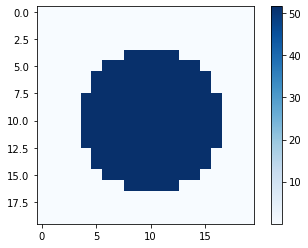

In [70]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar()

## 2) Applying a 2D FT (Fourier domain)

In [71]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 6.48489319e+02+7.03889502e+03j -3.55846741e+02-3.87283740e+03j
  -4.05775299e+01-4.42590057e+02j  4.90171165e+01+5.33408875e+02j
   4.76739883e+01+5.18308838e+02j  4.66200686e+00+5.13774376e+01j
  -3.00793037e+01-3.27770325e+02j -4.21415997e+00-4.61242180e+01j
  -5.18072176e+00-5.59800224e+01j -3.86656821e-01-4.31604910e+00j
   2.35069046e+01+2.56775940e+02j -4.32205319e-01-4.32231236e+00j
  -5.16073656e+00-5.60339737e+01j -4.26969576e+00-4.61398506e+01j
  -3.01010857e+01-3.27851624e+02j  4.75310898e+00+5.13570938e+01j
   4.76226616e+01+5.18223083e+02j  4.89821014e+01+5.33419861e+02j
  -4.06832314e+01-4.42705566e+02j -3.55874146e+02-3.87291870e+03j]
 [-3.55917328e+02-3.87293628e+03j  1.61673080e+02+1.76055237e+03j
   7.37149277e+01+8.02651245e+02j -2.85652809e+01-3.10279266e+02j
  -4.29667740e+01-4.67852417e+02j -9.99172401e+00-1.08305511e+02j
   1.30167398e+01+1.41595703e+02j  2.17955570e+01+2.35612930e+02j
   4.83373880e+00+5.13412323e+01j -1.05124636e+01-1.14903099e+02j
  -1.0011

## 3) Classification set

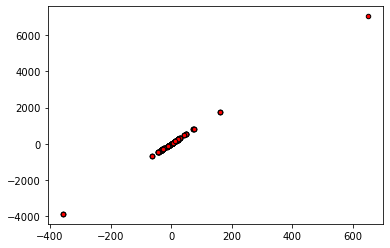

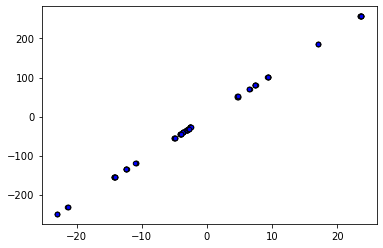

In [72]:
def labels(data, mask):
    """
    Generates labels 1/0 of a given vector of complex points.

    Args:
        data (complex): data points

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == True:
                label = 1
            else:
                label = 0
        
            yvals.append(label)
            Xvals.append((data[i][j].real, data[i][j].imag))
        
    return pnp.array(Xvals, requires_grad=False), pnp.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    
    reds = y == 0
    blues = y == 1
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.set_xlabel("Re")
    ax.set_ylabel("Img")
    plt.show()
    
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.show()
    
Xdata, ydata = labels(visibilities, mask)
#fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
#plt.show()


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * pnp.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = pnp.array([label_0, label_1], requires_grad=False)

## Simple classifier with data reloading and fidelity loss

In [21]:
dev = qml.device("default.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend
# https://docs.pennylane.ai/projects/qiskit/en/latest/
# https://docs.pennylane.ai/en/stable/introduction/interfaces.html


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

## Utility functions for testing and creating batches

In [68]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return pnp.array(predicted), pnp.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

## Train a quantum classifier on the circle dataset

In [80]:
# Generate training and test data
X_data, y_data = labels(visibilities, mask)
X_data = np.array(X_data)
index = int(0.8*len(X_data))
X_train, y_train = X_data[:index], y_data[:index]
X_test, y_test = X_data[index:], y_data[index:]
    
Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

print(qml.draw(qcircuit)(params,X_train[0],y_train[0]))

NameError: name 'circle' is not defined

In [25]:
# Generate training and test data
num_training = 200
num_test = 2000

Xdata, y_train = labels(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

TypeError: object of type 'int' has no len()

## Results

In [ ]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

## Utils

### Quantum

### Classical

In [3]:
#creates a circular mask over a 2D array
def circular_mask(h, w, center=None, radius=None):
    if center is None: #image center
        center = (int(w/2), int(h/2))
    if radius is None: #smallest distance between center and image bounderies
        radius = min(center[0], center[1], w-center[0], h-center[1])
        
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    
    return mask